In [1]:
import os
import sys
import math
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:
## Folder Locations
TEST_IMAGE_FOLDER = '../data/raw/Test/testset/'
TEST_CSV = '../data/raw/Test/testset.csv'

TRAIN_IMAGE_FOLDER = '../data/raw/Train/testset/'
TRAIN_CSV = '../data/raw/Train/testset.csv'


# VALID_IMAGE_FOLDER = '../data/raw/Train/testset/'
# VALID_CSV = '../data/raw/Valid/new_valid_set.csv'

In [4]:
train_set = pd.read_csv(TRAIN_CSV)
test_set = pd.read_csv(TEST_CSV)
train_set.head()

,Data,Label
0,600795.jpeg,10
1,627152.jpeg,10
2,119963.jpeg,10
3,118264.jpeg,10
4,199420.jpeg,10


In [5]:
test_set.head()

,Data,Label
0,632755.jpeg,10
1,496855.jpeg,10
2,155390.jpeg,10
3,265013.jpeg,10
4,496360.jpeg,10


In [6]:
test_set['Label'] = test_set['Label'].apply(str)
train_set['Label'] = train_set['Label'].apply(str)

In [7]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2609 non-null   object
 1   Label   2609 non-null   object
dtypes: object(2)
memory usage: 40.9+ KB


In [8]:
CLASSES = len(train_set['Label'].unique())

# Image Data generator

In [9]:
from keras_preprocessing.image import ImageDataGenerator

In [10]:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [32]:
TARGET_SIZE=(224, 224)


train_generator=datagen.flow_from_dataframe(
dataframe=train_set,
directory=TRAIN_IMAGE_FOLDER,
x_col="Data",
y_col="Label",
subset="training",
batch_size=32,
seed=RANDOM_STATE,
shuffle=True,
class_mode="categorical",
target_size=TARGET_SIZE)


valid_generator=datagen.flow_from_dataframe(
dataframe=train_set,
directory=TRAIN_IMAGE_FOLDER,
x_col="Data",
y_col="Label",
subset="validation",
batch_size=32,
seed=RANDOM_STATE,
shuffle=True,
class_mode="categorical",
target_size=TARGET_SIZE)


test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_set,
directory=TEST_IMAGE_FOLDER,
x_col="Data",
y_col="Label",
batch_size=32,
seed=RANDOM_STATE,
shuffle=False,
class_mode="categorical",
target_size=TARGET_SIZE)




Found 7200 validated image filenames belonging to 48 classes.
Found 2400 validated image filenames belonging to 48 classes.
Found 2609 validated image filenames belonging to 48 classes.


In [12]:
TARGET_SIZE[1]

224

## MobileNet

In [13]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from tensorflow.keras.optimizers import Adam

In [14]:
base_model = keras.applications.mobilenet.MobileNet(weights='imagenet',include_top=False)

In [15]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(48,activation='softmax')(x) #final layer with softmax activation

In [16]:
model=Model(inputs=base_model.input,outputs=preds)

In [17]:

for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [18]:
len(model.layers)

91

In [20]:

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                
                   epochs=5,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/5
225/225 [==============================] - 33s 148ms/step - loss: 0.0608 - accuracy: 0.9847 - val_loss: 30.8298 - val_accuracy: 0.0000e+00
Epoch 2/5
225/225 [==============================] - 33s 146ms/step - loss: 0.0489 - accuracy: 0.9871 - val_loss: 34.4311 - val_accuracy: 0.0000e+00
Epoch 3/5
225/225 [==============================] - 33s 146ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 27.3160 - val_accuracy: 0.0000e+00
Epoch 4/5
225/225 [==============================] - 33s 145ms/step - loss: 0.0577 - accuracy: 0.9865 - val_loss: 44.4879 - val_accuracy: 0.0000e+00
Epoch 5/5
225/225 [==============================] - 33s 146ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 49.4202 - val_accuracy: 0.0000e+00


In [40]:
predictions = model.predict(test_generator)

In [41]:
predicted_class_indices=np.argmax(predictions,axis=1)
predicted_class_indices

array([12,  3, 12, ..., 34, 34, 34])

In [42]:
labels = (test_generator.class_indices)

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '43': 38,
 '44': 39,
 '45': 40,
 '46': 41,
 '47': 42,
 '5': 43,
 '6': 44,
 '7': 45,
 '8': 46,
 '9': 47}

In [43]:
labels2 = dict((v,k) for k,v in labels.items())

{0: '0',
 1: '1',
 2: '10',
 3: '11',
 4: '12',
 5: '13',
 6: '14',
 7: '15',
 8: '16',
 9: '17',
 10: '18',
 11: '19',
 12: '2',
 13: '20',
 14: '21',
 15: '22',
 16: '23',
 17: '24',
 18: '25',
 19: '26',
 20: '27',
 21: '28',
 22: '29',
 23: '3',
 24: '30',
 25: '31',
 26: '32',
 27: '33',
 28: '34',
 29: '35',
 30: '36',
 31: '37',
 32: '38',
 33: '39',
 34: '4',
 35: '40',
 36: '41',
 37: '42',
 38: '43',
 39: '44',
 40: '45',
 41: '46',
 42: '47',
 43: '5',
 44: '6',
 45: '7',
 46: '8',
 47: '9'}

In [44]:
predictions = [labels2[k] for k in predicted_class_indices]

In [47]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(predictions, test_set['Label'])

In [48]:
acc

0.750095822154082

In [49]:
from sklearn.metrics import classification_report
print(classification_report(predictions, test_set['Label']))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        26
           1       1.00      1.00      1.00        33
          10       0.00      0.00      0.00         0
          11       1.00      0.91      0.95       103
          12       1.00      1.00      1.00        88
          13       0.84      1.00      0.91        77
          14       1.00      0.19      0.32        73
          15       1.00      1.00      1.00        50
          16       0.00      0.00      0.00         0
          17       1.00      1.00      1.00        14
          18       1.00      1.00      1.00        65
          19       1.00      1.00      1.00        74
           2       1.00      0.39      0.56        41
          20       1.00      1.00      1.00        86
          21       1.00      1.00      1.00        22
          22       1.00      0.52      0.69       155
          23       0.00      0.00      0.00         0
          24       1.00    

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


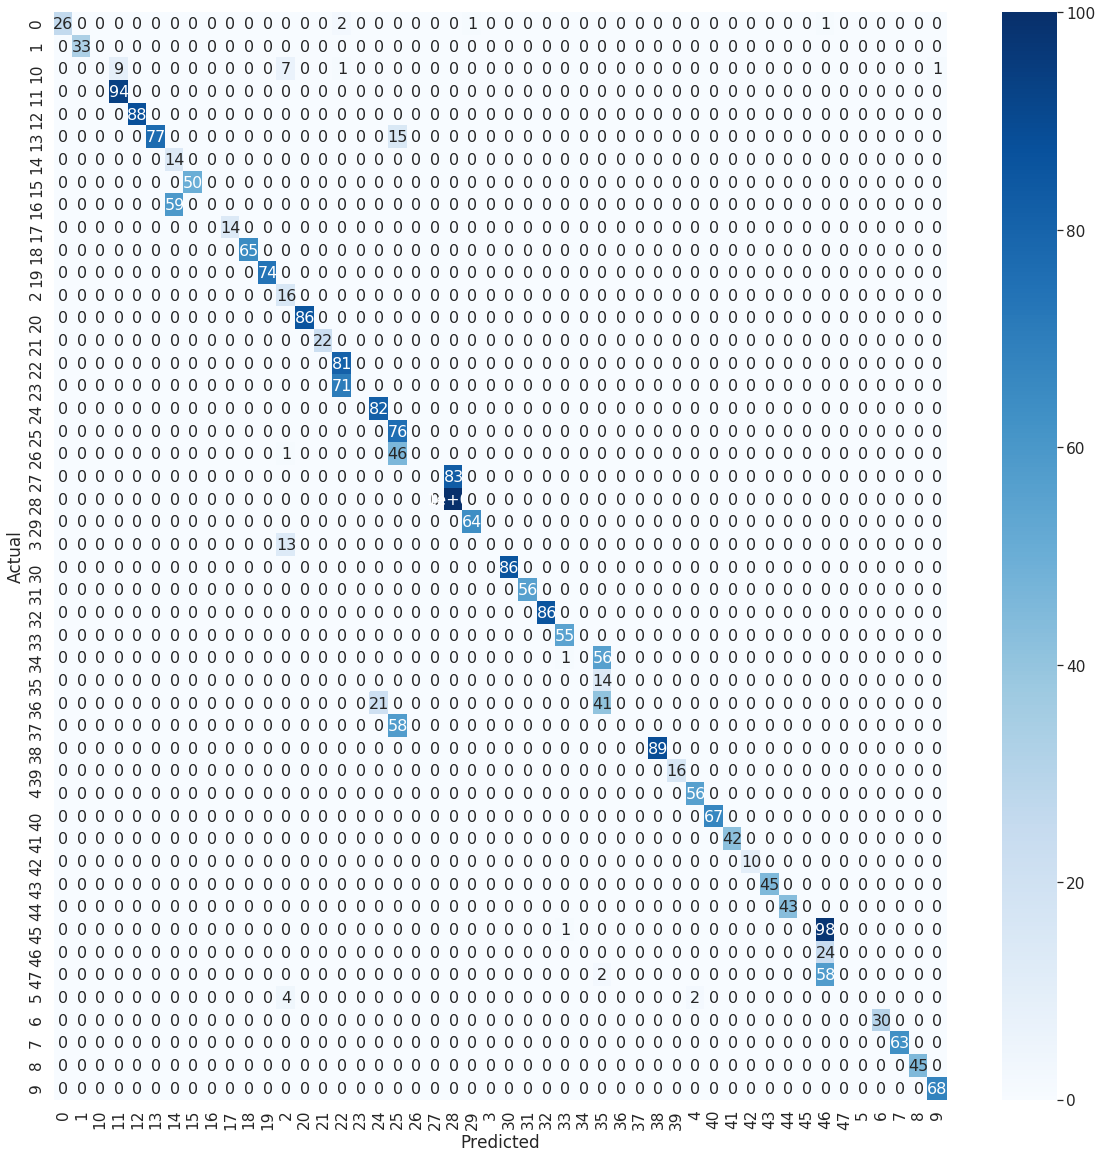

In [50]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

y_true = test_set['Label']
y_pred = predictions
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

## Saving model



In [51]:
model.save('./new_saved_models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./new_saved_models/assets


# Load and predict

In [52]:
from tensorflow import keras
mobnet = keras.models.load_model('./new_saved_models')

In [53]:
def get_image_for_prediction(dataframe):
    predict_datagen=ImageDataGenerator(rescale=1./255.)
    predict_generator=predict_datagen.flow_from_dataframe(
    dataframe=dataframe,
    directory=TEST_IMAGE_FOLDER,
    x_col="Data",
    y_col=None,
    batch_size=1,
    seed=RANDOM_STATE,
    shuffle=False,
    class_mode=None,
    target_size=TARGET_SIZE)
    
    return predict_generator

In [54]:
test_set.tail()

,Data,Label
2604,542827.jpeg,4
2605,962019.jpeg,4
2606,518649.jpeg,4
2607,299155.jpeg,4
2608,360063.jpeg,4


In [55]:
input_image_name = '518649.jpeg'

predict_df= test_set[test_set['Data']==input_image_name]

predict_data = get_image_for_prediction(predict_df)

Found 1 validated image filenames.


In [56]:
result = mobnet.predict(predict_data)
result = tensorflow.math.argmax(result, 1)

In [57]:
result

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([34])>

In [59]:
label = labels2[result.numpy()[0]]

In [60]:
label

'4'